In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import BGTools as bgt
import GTools as gt
import pandas as pd
import tracktor as tr
import os
import multiprocessing as mp

from scipy.spatial import distance
from itertools import combinations

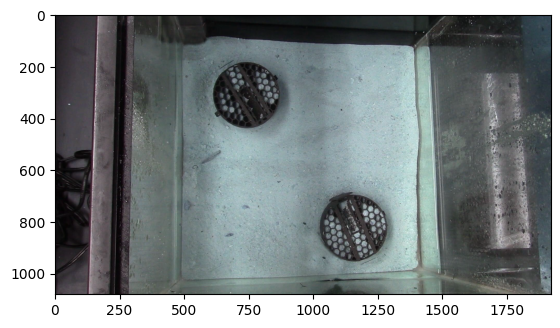

In [8]:
background = cv.imread("bg.jpg")
plt.imshow(background)

In [5]:
def TrackingSep(video, n_inds, data = None, min_area = 0, max_area=10000, cens = None, rads = None, iniB = None):
    
    t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]
    scaling = 1.0

    ## Individual location(s) measured in the last and current step
    meas_last = []
    meas_now = []

    df = []
    last = 0

    #count = -1
    for i in range(len(video)):
        
        this = i+1
        frame = video[this-1]
        frame = cv.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv.INTER_LINEAR)
        
        if data == None:
            thresh = tr.colour_to_thresh(frame)
        else:
            thresh = data[int(this-1)]
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)

        # Clear duplicates
        value = []
        for x,y in combinations(meas_now, 2):
            if euclidean(x, y) < 10 and not (y in value):
                value.append(y)
        for i in value:
            meas_now.remove(i)

        
        # Update Burrow locations
        while len(meas_now) < n_inds:
            meas_now.append([0,0])
        
        if len(meas_last) != len(meas_now):
            while len(meas_now) < len(meas_last):
                meas_now.append([0,0])

            while len(meas_last) < len(meas_now):
                meas_last.append([0,0])
        

        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, 0, col_ind, meas_now, df, False, this)
        
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], t_id[i]])

        
        #file[count].append(final)

        if cens != None and rads != None:
            for i in range(len(cens)):
                cv.circle(final, cens[i], rads[i], (255-50*i, 255, 50*i), 5)
                df.append([this, cens[i][0], cens[i][1], "Burrow {}".format(i+1)])

        if last >= this:
            break
        
        last = this
    
    return df

In [10]:
def MasterTracking(Video, back, start = 0, end = None):

    background, CropData, centers, radius, initBurrow = gt.InfoProcessor(back)

    n_inds = int(input("How many objects do you want to track? (Enter an integer):"))

    
    if isinstance(Video, str):
        video = gt.Video2Array(Video, CropData)
    video = Video

    processed = bgt.BackgroundSubtraction2(video, background)

    df = TrackingSep(video, n_inds, processed, 200, 8000, centers, radius, initBurrow)

    return df



In [11]:
df = MasterTracking("Video0006.MP4", background)

: 

: 